In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler



import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from matplotlib import rcParams

from statsmodels.graphics import tsaplots
import statsmodels.api as sm

Set Computational Device

In [2]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(device)

mps


Data Preprocessing

In [3]:
dataset = pd.read_csv('../data/SN_m_tot_V2.0.csv', delimiter=';', names=['Year', 'Month', 'Spaced Time','Sunspots','a','b','c'])

In [4]:
dataset.head()

,Year,Month,Spaced Time,Sunspots,a,b,c
0,1749,1,1749.042,96.7,-1.0,-1,1
1,1749,2,1749.123,104.3,-1.0,-1,1
2,1749,3,1749.204,116.7,-1.0,-1,1
3,1749,4,1749.288,92.8,-1.0,-1,1
4,1749,5,1749.371,141.7,-1.0,-1,1


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3277 entries, 0 to 3276
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Year         3277 non-null   int64  
 1   Month        3277 non-null   int64  
 2   Spaced Time  3277 non-null   float64
 3   Sunspots     3277 non-null   float64
 4   a            3277 non-null   float64
 5   b            3277 non-null   int64  
 6   c            3277 non-null   int64  
dtypes: float64(3), int64(4)
memory usage: 179.3 KB


In [6]:
dataset.columns

Index(['Year', 'Month', 'Spaced Time', 'Sunspots', 'a', 'b', 'c'], dtype='object')

In [7]:

# time = dataset.drop(['Year','Month','Sunspots','a','b','c'],axis=1)
dataset['Date'] = pd.to_datetime(dataset[['Year', 'Month']].assign(Day=1))
data = dataset.drop(['Year','Month','Spaced Time','a','b','c'],axis=1)
data = data.set_index('Date')

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3277 entries, 1749-01-01 to 2022-01-01
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Sunspots  3277 non-null   float64
dtypes: float64(1)
memory usage: 51.2 KB


In [14]:
#time.info()

Data Visualisation - Plot Data

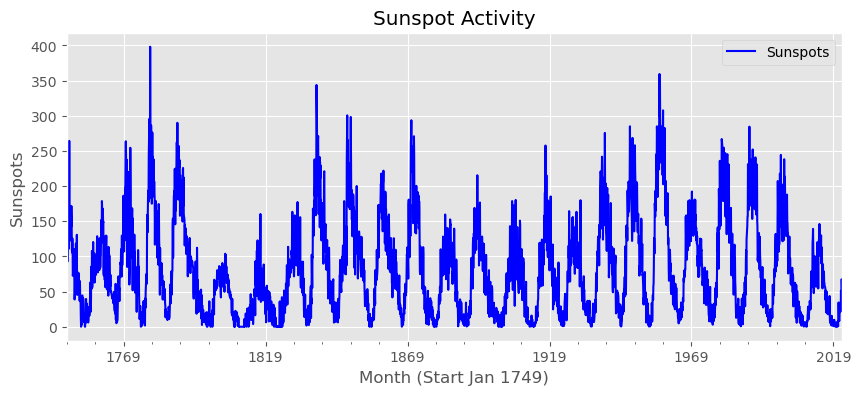

In [9]:
data.plot(figsize=(10, 4),color='blue')
plt.xlabel("Month (Start Jan 1749)")
plt.ylabel('Sunspots')
plt.title("Sunspot Activity")
plt.show()

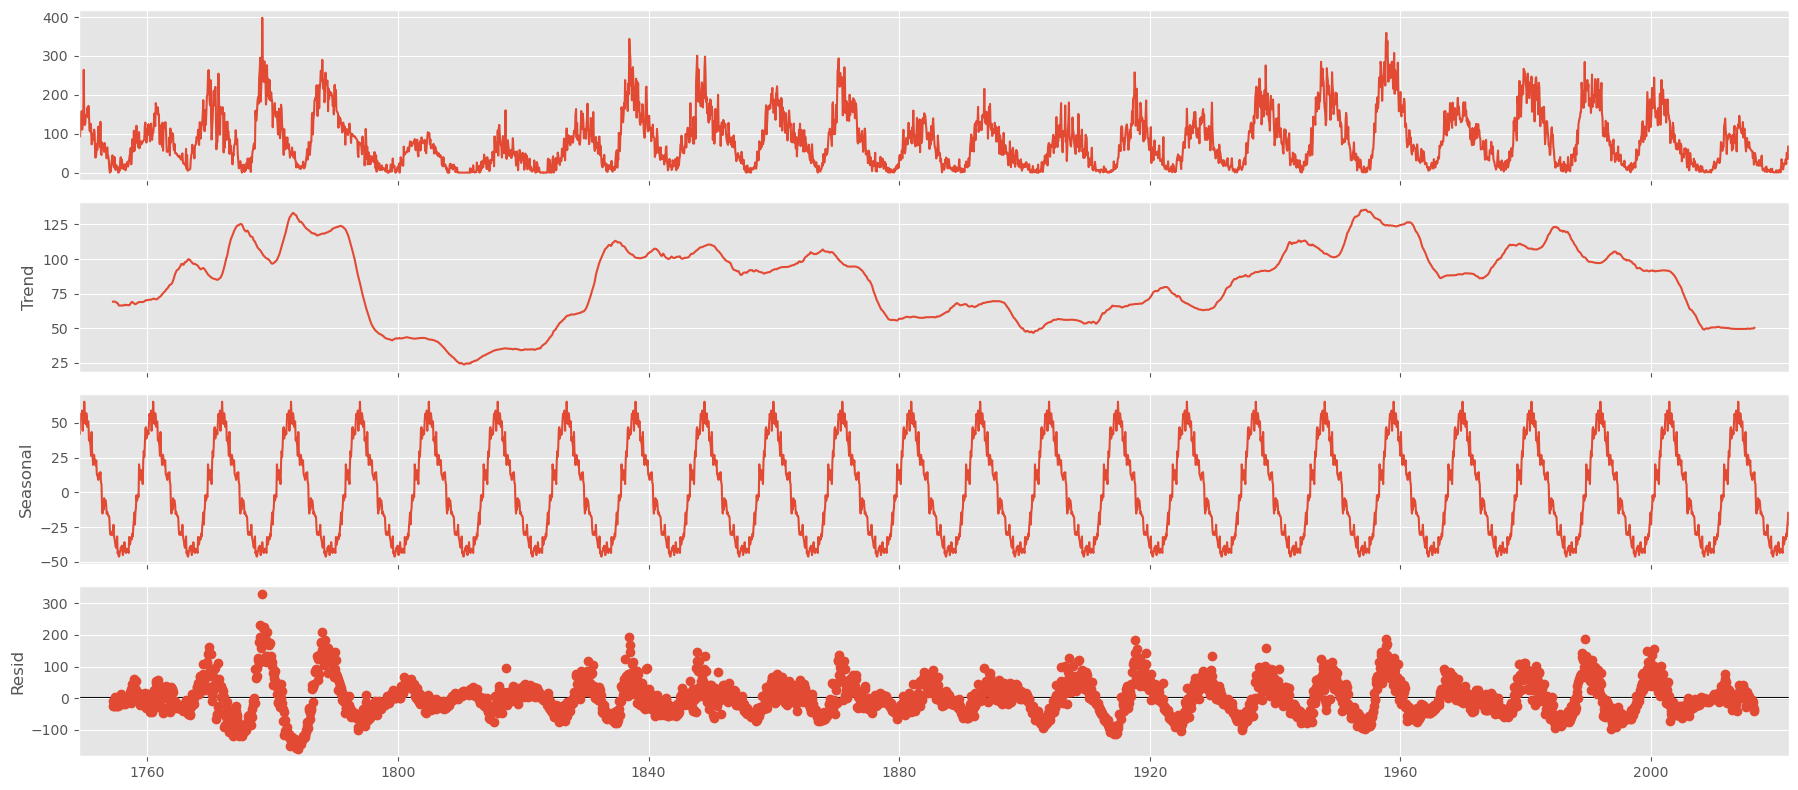

In [10]:
# Time-series decomposition
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(data, model='additive', period = 132)
fig = decomposition.plot()
plt.show()

Normalize Data

In [11]:
data_raw = data.to_numpy()

In [12]:
# Normalize data to zero mean and unit variance
# scaler = StandardScaler()
#scaler = QuantileTransformer(output_distribution='uniform')
# scaler = PowerTransformer()
scaler = MinMaxScaler()

data_scaled = scaler.fit_transform(data_raw)

Plot Normalized Data

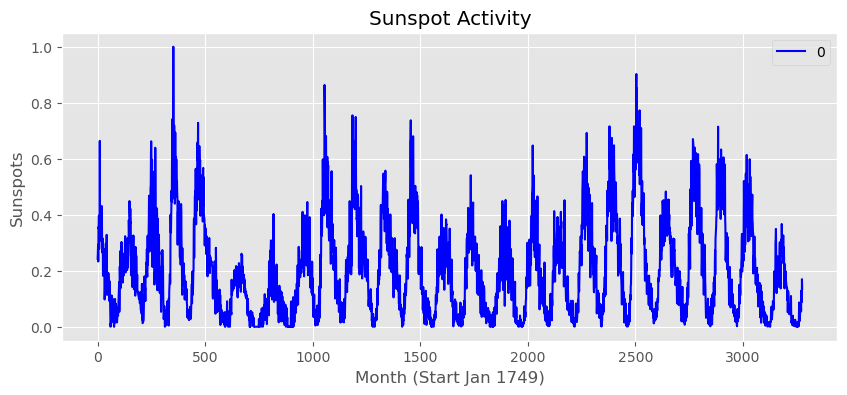

In [13]:
pd.DataFrame(data_scaled).plot(figsize=(10, 4),color='blue')
plt.xlabel("Month (Start Jan 1749)")
plt.ylabel('Sunspots')
plt.title("Sunspot Activity")
plt.show()

In [14]:
data_scaled.shape

(3277, 1)

In [15]:
# Split data using 2 seasonal cycles of data to predict
seasonal_length = 132
cycles_to_predict = 2

# Calculate train/test split
split = len(data) - (cycles_to_predict * seasonal_length )

# Length of data to train with
n_input = len(data) - split

# Target sequence values used to calculate performance metrics 
data_targets = data.to_numpy()[split:]

# Create train and test data sets
train_data = data_scaled[:split]
test_data = data_scaled[split:]
print(train_data.shape)
print(test_data.shape)


(3013, 1)
(264, 1)


In [16]:
print(split)

3013


Convert to sequences

In [17]:
# Convert training data into sequences (sliding windows) needed for LSTM. each sequence of 12 the target is the next value, i.e. 13th.
def create_sequences(data, n_input):
    sequences = []
    for i in range(len(data) - n_input):
        seq = data[i:i + n_input]
        label = data[i + n_input]
        sequences.append((seq, label))
    return sequences

train_sequences = create_sequences(train_data, n_input)

# Convert to PyTorch tensors
train_x = torch.tensor([seq[0] for seq in train_sequences], dtype=torch.float32).to(device)
train_y = torch.tensor([seq[1] for seq in train_sequences], dtype=torch.float32).to(device)

/var/folders/y7/nfq0trys2_x8ytsn7c7gzrdr0000gn/T/ipykernel_2034/983403349.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  train_x = torch.tensor([seq[0] for seq in train_sequences], dtype=torch.float32).to(device)


## Training Set-up (Shared Across Models)

In [18]:
# Parameters
n_features = 1
batch_size = 20
epochs = 100
n_runs = 3

### Dataset and DataLoader

In [19]:

train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

### Train Model Function

In [20]:
# Train the model
def train_model(model, train_loader, epochs):
    model.train()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)


    for epoch in range(epochs):
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
        scheduler.step(loss)
        if (epoch + 1) % 25 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

### Performance Evaluation Function

In [21]:
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape= np.mean(np.abs((y_true - y_pred) / (y_true+0.001))) * 100
    performance_data= {'MSE':round(mse, 2),
                      'RMSE':round(np.sqrt(mse), 2),
                       'MAPE':round(mape, 2)
                      }
    return performance_data

## Vanilla LSTM

### Define LSTM model

In [33]:
# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, n_input, n_features):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=50, batch_first=True)
        self.dropout = nn.Dropout(p=0.2)  # Dropout layer with a probability of 0.2
        self.fc1 = nn.Linear(50, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = self.dropout(lstm_out)  # Apply dropout
        x = torch.relu(self.fc1(lstm_out[:, -1, :]))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Vanilla LSTM Training

In [34]:
# Averaging over multiple runs (to keep the loop structure like in the original code)
store = np.zeros((n_input, n_runs))

for i in range(n_runs):
    model = LSTMModel(n_input, n_features).to(device)
    train_model(model, train_loader, epochs)
    pred_list = []

    batch = train_data[-n_input:].reshape((1, n_input, n_features))
    batch = torch.tensor(batch, dtype=torch.float32).to(device)

    with torch.no_grad():
        for j in range(n_input):
            pred = model(batch).item()
            pred_list.append(pred)
            # Update the batch by appending the prediction and removing the first element
            pred_tensor = torch.tensor([[[pred]]], dtype=torch.float32).to(device)  # Ensure pred is on device
            batch = torch.cat((batch[:, 1:, :], pred_tensor), dim=1)

    store[:, i] = scaler.inverse_transform(np.array(pred_list).reshape(-1, 1)).flatten()

# Averaging predictions
final_vanilla = np.mean(store, axis=1)

Epoch [25/100], Loss: 0.0099
Epoch [50/100], Loss: 0.0091
Epoch [75/100], Loss: 0.0092
Epoch [100/100], Loss: 0.0094
Epoch [25/100], Loss: 0.0107
Epoch [50/100], Loss: 0.0111
Epoch [75/100], Loss: 0.0107
Epoch [100/100], Loss: 0.0109
Epoch [25/100], Loss: 0.0093
Epoch [50/100], Loss: 0.0102
Epoch [75/100], Loss: 0.0112
Epoch [100/100], Loss: 0.0092


### Vanilla LSTM predictions

In [35]:
print(final_vanilla.shape)
print(final_vanilla)

(264,)
[141.80943668 151.36280267 153.31810794 148.372239   149.98176719
 154.08558898 155.01109874 154.36990143 149.49974577 147.21316525
 143.76039852 143.49003804 144.3160604  138.00404941 141.38283944
 135.77953875 134.84815073 132.47044133 132.25518856 125.4688699
 121.42929758 119.88755928 123.88194889 122.24001906 117.02767024
 114.48722872 113.24344233 112.91302944 107.24127627 105.39080462
 105.21600743 101.04075051 101.05489038  98.4633246   93.36246299
  92.82988298  90.60428646  90.28970848  85.8975176   82.13794991
  75.70750541  78.03172302  74.30194618  72.34949104  76.92190839
  72.9106534   68.60763923  64.42527777  63.9823017   60.29468536
  56.6242311   55.04998633  50.44373435  48.76844954  49.81339166
  42.38468895  43.14921108  42.18870371  35.64434118  38.06875131
  37.35700893  33.59540156  31.70778481  27.87442536  29.69463642
  27.10248025  25.7644968   22.3618466   20.23219312  20.65689061
  17.33449936  16.95511907  16.03914319  16.30333467  12.98478891
  16

### Vanilla LSTM Prediction Visualization

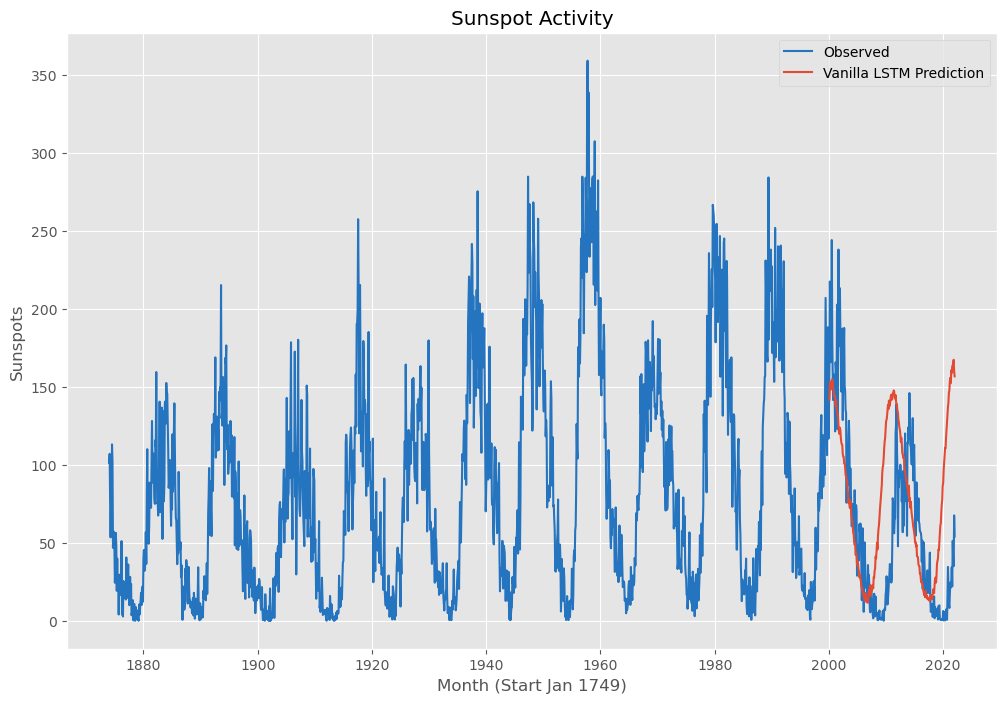

In [36]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(data[1500:],label="Observed",color='#2574BF')
plt.plot(data[split:].index,final_vanilla,label="Vanilla LSTM Prediction")
plt.xlabel("Month (Start Jan 1749)")
plt.ylabel('Sunspots')
plt.title("Sunspot Activity")
plt.legend()
plt.show()

### Vanilla LSTM Perfomance Metrics

In [37]:
vanilla_lstm = performance(data_targets,final_vanilla)
vanilla_lstm

{'MSE': np.float64(5929.23),
 'RMSE': np.float64(77.0),
 'MAPE': np.float64(31204.13)}

## Stacked LSTM


### Define Stacked LSTM model

In [44]:
# Define the stacked LSTM model
class StackedLSTMModel(nn.Module):
    def __init__(self, n_input, n_features):
        super(StackedLSTMModel, self).__init__()
        # First LSTM layer (returns entire sequences)
        self.lstm1 = nn.LSTM(input_size=n_features, hidden_size=50, batch_first=True, dropout=0.25 ,num_layers=2)
        # Second LSTM layer (returns entire sequences)
        self.lstm2 = nn.LSTM(input_size=50, hidden_size=50, batch_first=True)
        #manual dropout
        self.dropout = nn.Dropout(0.2)
        # Fully connected layers
        self.fc1 = nn.Linear(50, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 1)

    def forward(self, x):
        lstm_out1, _ = self.lstm1(x)
        lstm_out2, _ = self.lstm2(lstm_out1)
        x = lstm_out2[:, -1, :]  # Get the last time step output
        #x = self.dropout(x)  # Apply dropout here
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Stacked LSTM Training

In [45]:
# Train and predict multiple times
store2 = np.zeros((n_input, n_runs))

for i in range(n_runs):
    # Initialize the model
    model_stacked = StackedLSTMModel(n_input=n_input, n_features=n_features).to(device)
    
    # Train the model
    train_model(model_stacked, train_loader, epochs)
    
    # Make predictions
    pred_list_s = []
    batch = train_data[-n_input:].reshape((1, n_input, n_features))
    batch = torch.tensor(batch, dtype=torch.float32).to(device)

    with torch.no_grad():
        for j in range(n_input):
            pred = model_stacked(batch).item()  # Get prediction
            pred_list_s.append(pred)
            # Update the batch by appending the predicted value
            pred_tensor = torch.tensor([[[pred]]], dtype=torch.float32).to(device)  # Ensure pred is on device
            batch = torch.cat((batch[:, 1:, :], pred_tensor), dim=1)
            
 # Inverse transform the predictions and store them
    store2[:, i] = scaler.inverse_transform(np.array(pred_list_s).reshape(-1, 1)).flatten()

# Average the results across runs (if needed)
final_stacked = np.mean(store2, axis=1)

Epoch [25/100], Loss: 0.0125
Epoch [50/100], Loss: 0.0118
Epoch [75/100], Loss: 0.0109
Epoch [100/100], Loss: 0.0105
Epoch [25/100], Loss: 0.0104
Epoch [50/100], Loss: 0.0104
Epoch [75/100], Loss: 0.0104
Epoch [100/100], Loss: 0.0104
Epoch [25/100], Loss: 0.0100
Epoch [50/100], Loss: 0.0086
Epoch [75/100], Loss: 0.0075
Epoch [100/100], Loss: 0.0051


### Stacked LSTM Predictions

In [46]:
print(final_stacked)
print(final_stacked.shape)

[140.12671108 141.68945052 137.75067497 136.2551281  135.71768646
 133.3282245  130.79917557 129.56531024 127.23550511 125.66270617
 123.3629055  122.33441144 119.66741719 115.55556323 111.83526439
 107.98315562 104.22462434 100.93995771  96.36539633  91.91964642
  88.85197308  86.02346311  83.06272193  79.98646854  77.02159358
  74.10007179  70.77551724  66.70628067  62.53936349  58.49180449
  54.86890343  52.0309738   49.69715556  47.84662062  46.51722463
  45.51878249  44.58660431  43.70146606  43.0134889   42.31940999
  41.47487318  40.44002518  39.00940274  37.42559046  35.78615326
  34.22213363  33.04919593  32.14972991  31.54693267  31.46976169
  31.35053553  31.03317813  30.61492062  30.7616863   32.14909353
  34.55431723  38.30761305  41.2342002   44.85173824  49.39261927
  54.3917565   58.99372438  63.51596982  67.98710287  70.82084433
  74.06330299  78.31306865  82.47057309  86.06769248  88.48530068
  89.82723841  91.6020759   93.98762166  97.22692165 101.17604844
 105.48911

### Stacked LSTM Prediction Visualisation

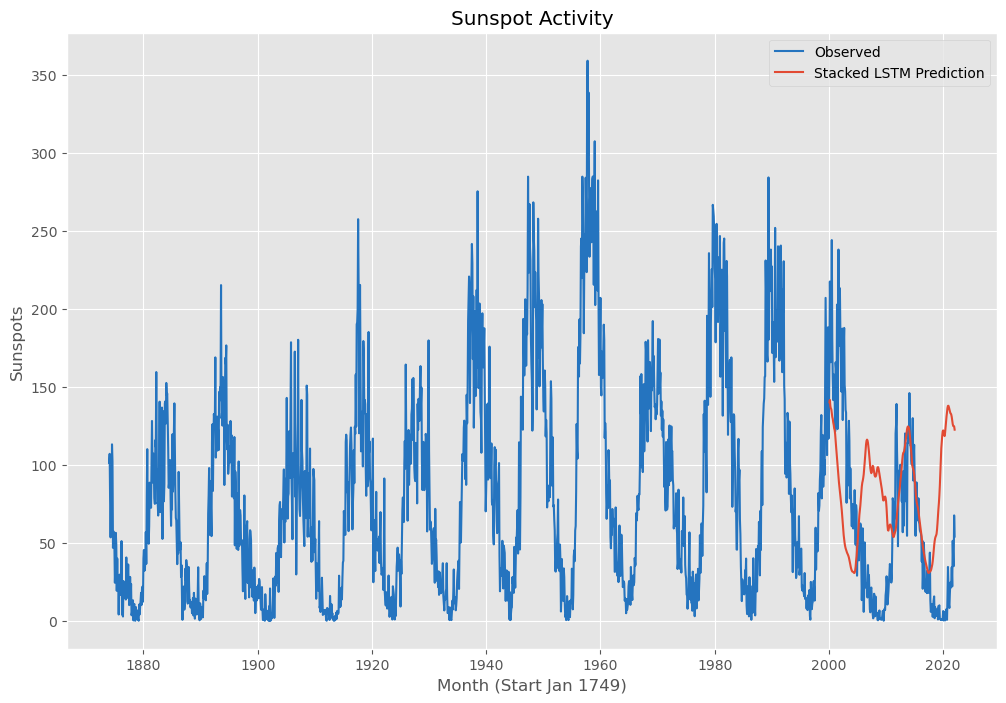

In [47]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(data[1500:],label="Observed",color='#2574BF')
plt.plot(data[split:].index,final_stacked,label="Stacked LSTM Prediction")
plt.xlabel("Month (Start Jan 1749)")
plt.ylabel('Sunspots')
plt.title("Sunspot Activity")
plt.legend()
plt.show()

In [48]:
stacked_lstm= performance(data_targets,final_stacked)
stacked_lstm

{'MSE': np.float64(4723.06),
 'RMSE': np.float64(68.72),
 'MAPE': np.float64(32623.78)}

## Biirectional LSTM

In [22]:
# Define bidirectional LSTM model 
class BidirectionalLSTMModel(nn.Module):
    def __init__(self, n_input, n_features):
        super(BidirectionalLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=50, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(p=0.2)  # Dropout layer with a probability of 0.2
        self.fc1 = nn.Linear(100, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = self.dropout(lstm_out)  # Apply dropout
        x = torch.relu(self.fc1(lstm_out[:, -1, :]))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Bidirectional LSTM Training

In [23]:
# Train and predict multiple times
store3 = np.zeros((n_input, n_runs))

for i in range(n_runs):
    # Initialize the model
    model_bidirec = BidirectionalLSTMModel(n_input=n_input, n_features=n_features).to(device)
    
    # Train the model
    train_model(model_bidirec, train_loader, epochs)
    
    # Make predictions
    pred_list_s = []
    batch = train_data[-n_input:].reshape((1, n_input, n_features))
    batch = torch.tensor(batch, dtype=torch.float32).to(device)

    with torch.no_grad():
        for j in range(n_input):
            pred = model_bidirec(batch).item()  # Get prediction
            pred_list_s.append(pred)
            # Update the batch by appending the predicted value
            pred_tensor = torch.tensor([[[pred]]], dtype=torch.float32).to(device)  # Ensure pred is on device
            batch = torch.cat((batch[:, 1:, :], pred_tensor), dim=1)


    # Inverse transform the predictions and store them
    store3[:, i] = scaler.inverse_transform(np.array(pred_list_s).reshape(-1, 1)).flatten()

# Average the results across runs (if needed)
final_bidirec = np.mean(store3, axis=1)

Epoch [25/100], Loss: 0.0090
Epoch [50/100], Loss: 0.0104
Epoch [75/100], Loss: 0.0086
Epoch [100/100], Loss: 0.0087
Epoch [25/100], Loss: 0.0105
Epoch [50/100], Loss: 0.0089
Epoch [75/100], Loss: 0.0089
Epoch [100/100], Loss: 0.0100
Epoch [25/100], Loss: 0.0090
Epoch [50/100], Loss: 0.0104
Epoch [75/100], Loss: 0.0095
Epoch [100/100], Loss: 0.0081


### Bidirectional LSTM Predictions

In [24]:
print(final_bidirec)
print(final_bidirec.shape)

[150.45996734 157.05521085 157.41054505 159.40846573 154.37884145
 154.12374625 156.90642279 155.25231712 156.67130419 147.80277547
 148.48603044 147.2222279  141.14166457 140.91776451 142.5560946
 139.34231916 137.93507676 135.12026361 132.37352517 129.73155903
 129.02473564 123.70734553 117.15235189 117.43482095 116.65368067
 114.97084826 113.21408267 111.3701677  109.16801104 105.15633872
 100.51174849  99.09774964  93.32295086  91.72902024  91.27822561
  89.51452755  87.53422385  84.15358252  82.89953292  80.15472884
  78.68942574  75.23490464  73.65242397  70.57021321  68.82367524
  65.96037039  64.57869407  58.78133361  55.30364459  51.7731788
  51.70364541  46.96200947  41.2375616   43.84560511  40.38388155
  38.41683262  37.19136933  36.37287478  33.63513075  30.3424626
  28.27765543  25.49565582  23.06131524  21.30003811  20.74316626
  19.94604421  18.45484669  15.36149948  15.69247805  12.57038728
  12.97983877  15.52373416  13.83040811  11.81280207  12.44078837
  10.02776712

### Bidirectional LSTM Prediction Visualisation

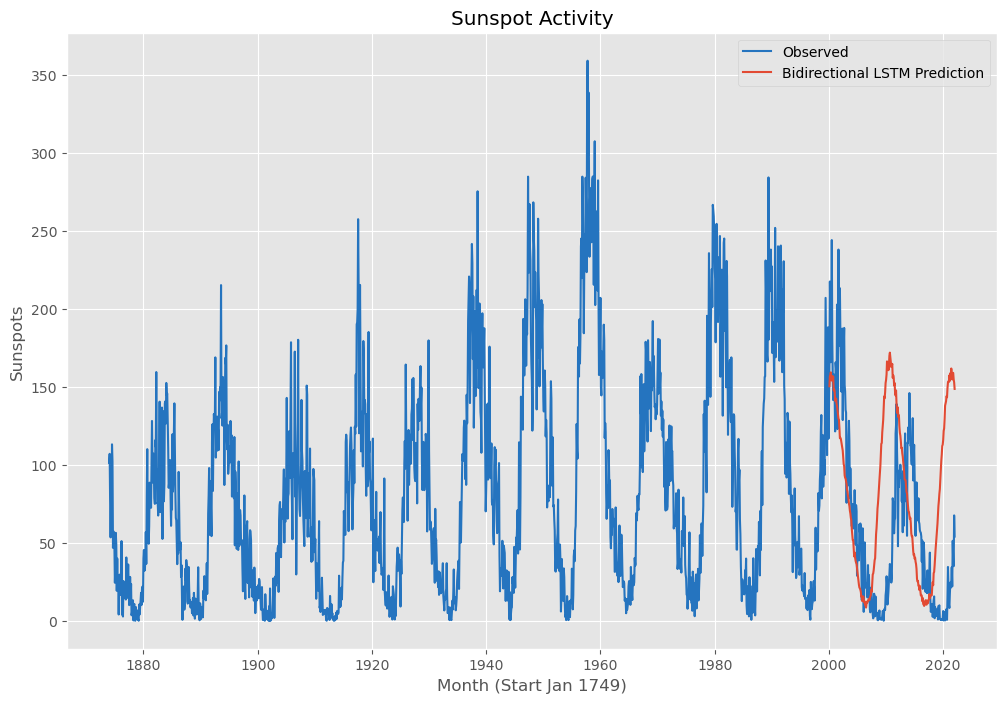

In [25]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(data[1500:],label="Observed",color='#2574BF')
plt.plot(data[split:].index,final_bidirec,label="Bidirectional LSTM Prediction")
plt.xlabel("Month (Start Jan 1749)")
plt.ylabel('Sunspots')
plt.title("Sunspot Activity")
plt.legend()
plt.show()

In [26]:
bidirec_lstm = performance(data_targets,final_bidirec)
bidirec_lstm

{'MSE': np.float64(6597.02),
 'RMSE': np.float64(81.22),
 'MAPE': np.float64(32763.04)}

## Convolutional Neural Network

In [27]:
# CNN Model
class CNNModel(nn.Module):
    def __init__(self, n_input, n_features):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(n_input, 128, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(128, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(128, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128, 100)
        self.fc2 = nn.Linear(100,1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        # x = torch.avg_pool1d(x, kernel_size=3, padding=1, count_include_pad=False)
        x = torch.max_pool1d(x, kernel_size=3, padding=1)
        x = torch.flatten(x,1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### CNN Model Training

In [28]:
# Averaging over multiple runs (to keep the loop structure like in the original code)
store4 = np.zeros((n_input, n_runs))

for i in range(n_runs):
    #reset_weights(model)  # Reset the weights to random
    model = CNNModel(n_input, n_features).to(device)
    train_model(model, train_loader, epochs)
    pred_list = []

    batch = train_data[-n_input:].reshape((1, n_input, n_features))
    batch = torch.tensor(batch, dtype=torch.float32).to(device)

    with torch.no_grad():
        for j in range(n_input):
            pred = model(batch).item()
            pred_list.append(pred)
           # Update the batch by appending the prediction and removing the first element
            pred_tensor = torch.tensor([[[pred]]], dtype=torch.float32).to(device)  # Ensure pred is on device
            batch = torch.cat((batch[:, 1:, :], pred_tensor), dim=1)

    store4[:, i] = scaler.inverse_transform(np.array(pred_list).reshape(-1, 1)).flatten()

# Averaging predictions
final_cnn = np.mean(store4, axis=1)

Epoch [25/100], Loss: 0.0097
Epoch [50/100], Loss: 0.0086
Epoch [75/100], Loss: 0.0086
Epoch [100/100], Loss: 0.0085
Epoch [25/100], Loss: 0.0082
Epoch [50/100], Loss: 0.0078
Epoch [75/100], Loss: 0.0019
Epoch [100/100], Loss: 0.0036
Epoch [25/100], Loss: 0.0089
Epoch [50/100], Loss: 0.0069
Epoch [75/100], Loss: 0.0075
Epoch [100/100], Loss: 0.0065


### CNN Predictions

In [29]:
print(final_cnn)
print(final_cnn.shape)

[154.33121804 162.27106052 173.00060497 176.02831324 175.76754944
 180.64065214 186.24390141 184.08563789 189.34788468 184.87724907
 182.16818926 189.42967401 190.16342823 184.50261867 184.54814158
 188.59838258 188.54011817 190.36733587 189.50497984 187.46081631
 185.76006034 183.27549791 180.93139271 175.81756609 173.06032114
 170.5154017  171.0164266  171.60532874 171.77800169 172.08204152
 168.92120209 165.31590515 162.55427723 158.99470889 157.34618481
 151.23815662 148.59371418 147.99884279 146.58982821 141.50473624
 139.7868993  132.47783069 123.79549967 122.29473515 118.06828079
 107.10865738 103.54963099 102.01606133 100.5497416   99.43541939
  98.9357889   95.3477015   95.137075    93.06176379  90.66385628
  88.69313739  87.44974658  86.22914887  85.5611315   85.05295854
  82.29865669  79.71285247  76.10258907  72.19334328  72.44542023
  71.93539005  74.90918723  71.52897312  69.18448223  66.47321511
  64.67173952  60.93628913  59.15906335  59.07061647  55.92230296
  51.57686

### CNN Prediction Visualisation

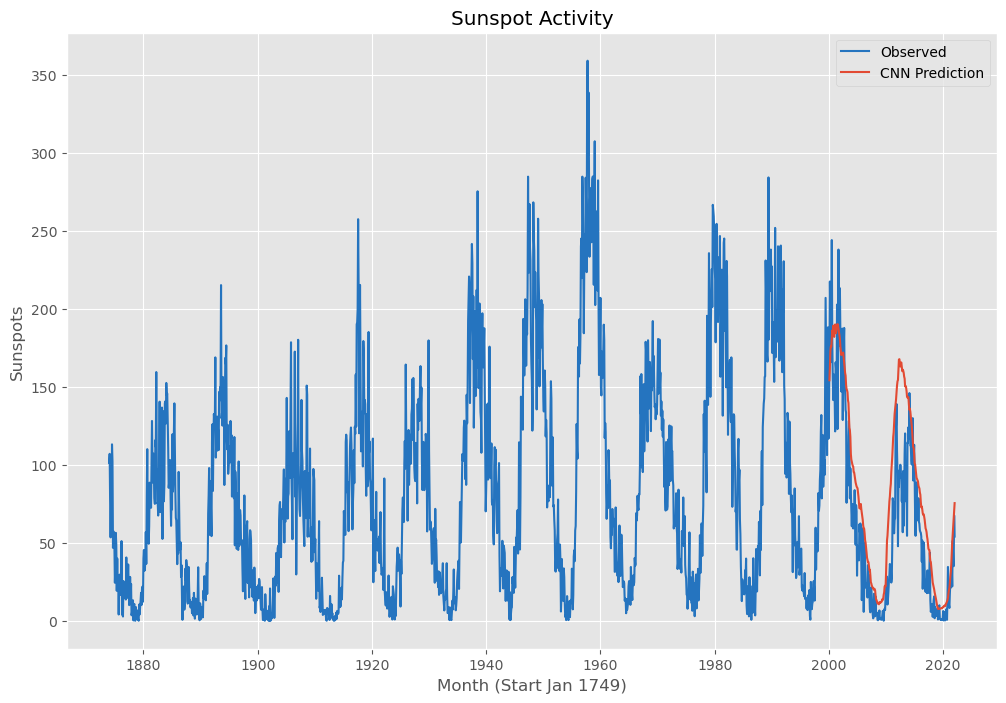

In [30]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(data[1500:],label="Observed",color='#2574BF')
plt.plot(data[split:].index,final_cnn,label="CNN Prediction")
plt.xlabel("Month (Start Jan 1749)")
plt.ylabel('Sunspots')
plt.title("Sunspot Activity")
plt.legend()
plt.show()

In [31]:
cnn = performance(data_targets,final_cnn)
cnn

{'MSE': np.float64(7285.95),
 'RMSE': np.float64(85.36),
 'MAPE': np.float64(33258.38)}

# Compare results

In [49]:
print(f"Vanilla LSTM: {vanilla_lstm}")
print(f"Stacked LSTM: {stacked_lstm}")
print(f"Bidirec LSTM: {bidirec_lstm}")
print(f"Conv NN LSTM: {cnn}")

Vanilla LSTM: {'MSE': np.float64(5929.23), 'RMSE': np.float64(77.0), 'MAPE': np.float64(31204.13)}
Stacked LSTM: {'MSE': np.float64(4723.06), 'RMSE': np.float64(68.72), 'MAPE': np.float64(32623.78)}
Bidirec LSTM: {'MSE': np.float64(6597.02), 'RMSE': np.float64(81.22), 'MAPE': np.float64(32763.04)}
Conv NN LSTM: {'MSE': np.float64(7285.95), 'RMSE': np.float64(85.36), 'MAPE': np.float64(33258.38)}


## Visualization - all models

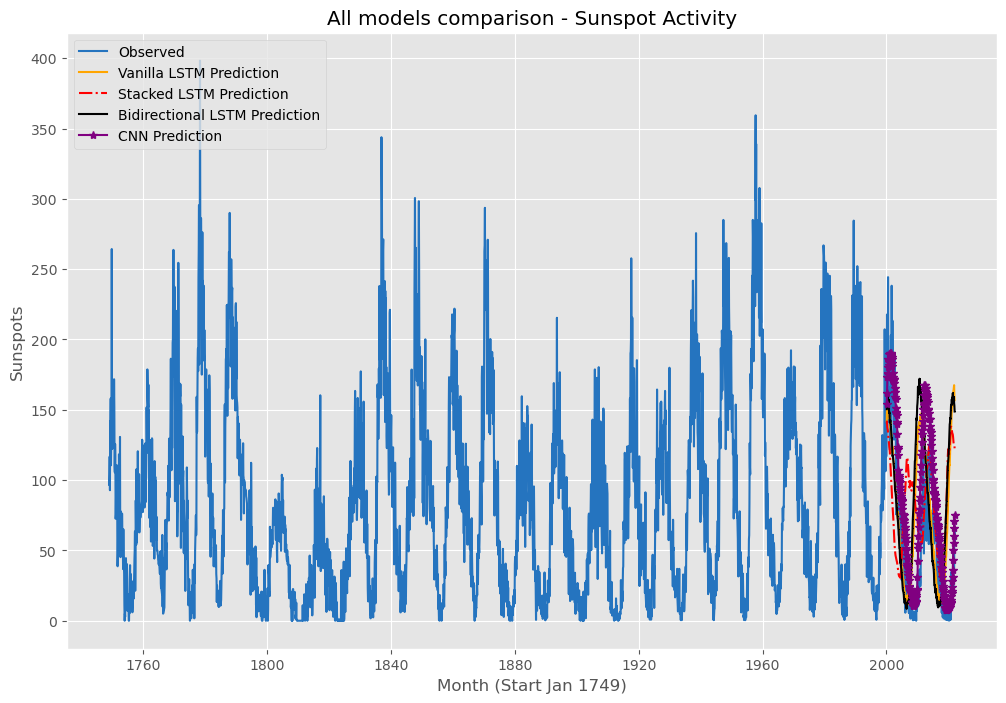

In [50]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(data.index,data,label="Observed",color='#2574BF')
#Vanilla LSTM
plt.plot(data[split:].index,final_vanilla,label="Vanilla LSTM Prediction",linestyle= "-", color='orange')
#Stacked LSTM
plt.plot(data[split:].index,final_stacked,label="Stacked LSTM Prediction",linestyle= "-.", color="red")
#Bidirectional LSTM
plt.plot(data[split:].index,final_bidirec,label="Bidirectional LSTM Prediction",marker=',',color='black')
#CNN model
plt.plot(data[split:].index,final_cnn,label="CNN Prediction",marker="*",color="purple")
plt.title('All models comparison - Sunspot Activity')
plt.xlabel("Month (Start Jan 1749)")
plt.ylabel('Sunspots')
plt.legend(loc='upper left')
plt.show()